<a href="https://colab.research.google.com/github/adamdavidcole/stylegan3-fun-blend/blob/main/blend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Network Blending Experiment

test github connect

## Setup Google Drive Connection

In [1]:
# Check GPU connection
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-2adafe90-0fba-6397-53a9-da6d63a7ca26)


In [2]:
# Connect Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
!pip install gdown --upgrade

if os.path.isdir("/content/drive/MyDrive/stylegan3-fun-blend"):
    %cd "/content/drive/MyDrive/stylegan3-fun-blend"
elif os.path.isdir("/content/drive/"):
    #install script
    %cd "/content/drive/MyDrive/"
    !git clone https://github.com/adamdavidcole/stylegan3-fun-blend.git
    %cd stylegan3-fun-blend
    !mkdir downloads
    !mkdir datasets
    !mkdir pretrained
    # !gdown --id 1-5xZkD8ajXw1DdopTkH_rAoCsD72LhKU -O /content/drive/MyDrive/colab-sg2-ada-pytorch/stylegan2-ada-pytorch/pretrained/wikiart.pkl
else:
    !git clone https://github.com/adamdavidcole/stylegan3-fun-blend.git
    %cd stylegan3-fun-blend
    !mkdir downloads
    !mkdir datasets
    !mkdir pretrained

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/content/drive/MyDrive/stylegan3-fun-blend


In [ ]:
# ONLY IF NECESSARY: Update all code files in drive repo 
!git config --global user.name "test"
!git config --global user.email "test@test.com"
!git fetch origin
!git pull
!git stash
!git checkout origin/main -- "*.py" 
!git checkout origin/main -- "*.ipynb"

Already up to date.
Saved working directory and index state WIP on main: 59cff72 drive+collab test3


In [4]:
!pip install einops ninja gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 108 kB 21.6 MB/s 


In [5]:
import numpy as np
from datetime import datetime
import torch
import dnnlib
from dnnlib.util import format_time
import legacy
import PIL.Image

from torch_utils import gen_utils



## Network Setup

In [6]:
network_key = "butterfly"
cfg="stylegan3-r"
pretrained_network = "ffhqu256"
dataset = "/content/drive/MyDrive/stylegan3/datasets/butterflys_256_2-256x256.zip"

results_outdir = f"./results/{network_key}"
training_outdir = f"{results_outdir}/training"

if not os.path.isdir(training_outdir):
    !mkdir -p $results_outdir

## Training

In [ ]:
!python train.py --outdir=$training_outdir --data=$dataset \
    --gpus=1 --batch=32 --batch-gpu=16  --gamma=6.6 --mirror=1 --kimg=50 --snap=1 --tick=1 --img-snap=1 --cbase=16384 \
    --cfg=$cfg --resume=$pretrained_network

Creating output directory...

Training options:
{
  "G_kwargs": {
    "class_name": "training.networks_stylegan3.Generator",
    "z_dim": 512,
    "w_dim": 512,
    "mapping_kwargs": {
      "num_layers": 2,
      "freeze_layers": 0,
      "freeze_embed": false
    },
    "channel_base": 32768,
    "channel_max": 1024,
    "magnitude_ema_beta": 0.9988915792636801,
    "conv_kernel": 1,
    "use_radial_filters": true
  },
  "D_kwargs": {
    "class_name": "training.networks_stylegan2.Discriminator",
    "block_kwargs": {
      "freeze_layers": 0
    },
    "mapping_kwargs": {},
    "epilogue_kwargs": {
      "mbstd_group_size": 4
    },
    "channel_base": 16384,
    "channel_max": 512
  },
  "G_opt_kwargs": {
    "class_name": "torch.optim.Adam",
    "betas": [
      0,
      0.99
    ],
    "eps": 1e-08,
    "lr": 0.0025
  },
  "D_opt_kwargs": {
    "class_name": "torch.optim.Adam",
    "betas": [
      0,
      0.99
    ],
    "eps": 1e-08,
    "lr": 0.002
  },
  "loss_kwargs": {
   

## Projection

In [7]:
projection_source_images_outdir = "projection_source_images"
projection_source_vectors_outdir = "projection_source_vectors"


In [268]:
# Upload File 
if not os.path.isdir(projection_source_images_outdir):
  !mkdir -p $projection_source_images_outdir

def upload_files():
  filepaths = []
  from google.colab import files
  uploaded = files.upload()
  for k, v in uploaded.items():
    filepath = f"{projection_source_images_outdir}/{k}"
    open(filepath, 'wb').write(v)
    filepaths.append(filepath)
  return list(filepaths)

uploaded = upload_files();
print(uploaded)

[]


In [ ]:
# Project Image
# uploaded_file = uploaded[0]
uploaded_file="/content/drive/MyDrive/stylegan3-fun-blend/projection_source_images/alan3.jpg"
uploaded_file_name = uploaded_file.split('/')[-1].split('.')[0:-1]
uploaded_file_name = ''.join(uploaded_file_name)
print(uploaded_file)

!python projector.py --outdir=$projection_source_vectors_outdir --target=$uploaded_file --project-in-wplus --num-steps=5000 --save-video --stabilize-projection \
       --cfg=stylegan3-r --network=ffhqu256

## Projection Generation

In [213]:
### Get set of most recent training checkpoints
most_recent_training_result = os.listdir(training_outdir)[-1]
print(most_recent_training_result)

path_to_most_recent_training_result = f"{training_outdir}/{most_recent_training_result}"
training_checkpoints = [f"{path_to_most_recent_training_result}/{f}" for f in os.listdir(path_to_most_recent_training_result) if f.endswith('.pkl')]
print(training_checkpoints)

00008-stylegan3-r-butterflys_256_2-256x256-gpus1-batch32-gamma6.6-resume_ffhqu256
['./results/butterfly/training/00008-stylegan3-r-butterflys_256_2-256x256-gpus1-batch32-gamma6.6-resume_ffhqu256/network-snapshot-000000.pkl', './results/butterfly/training/00008-stylegan3-r-butterflys_256_2-256x256-gpus1-batch32-gamma6.6-resume_ffhqu256/network-snapshot-000001.pkl', './results/butterfly/training/00008-stylegan3-r-butterflys_256_2-256x256-gpus1-batch32-gamma6.6-resume_ffhqu256/network-snapshot-000002.pkl', './results/butterfly/training/00008-stylegan3-r-butterflys_256_2-256x256-gpus1-batch32-gamma6.6-resume_ffhqu256/network-snapshot-000003.pkl', './results/butterfly/training/00008-stylegan3-r-butterflys_256_2-256x256-gpus1-batch32-gamma6.6-resume_ffhqu256/network-snapshot-000004.pkl', './results/butterfly/training/00008-stylegan3-r-butterflys_256_2-256x256-gpus1-batch32-gamma6.6-resume_ffhqu256/network-snapshot-000005.pkl', './results/butterfly/training/00008-stylegan3-r-butterflys_256_2-

In [ ]:
# projected_w_path = f"{projection_source_vectors_outdir}/00001-projection-w-wavgstart-sgan2/projected_wavg_final.npy"
# result_name="test_result"

ffhqu256_pkl = gen_utils.resume_specs["stylegan3-r"]["ffhqu256"];
# projection_network_pkl = gen_utils.resume_specs["stylegan3-r"]["ffhqu256"];
network_name="stylegan3-r_ffhqu256"

# projection_network_pkl = 

projection_outdir=f"{results_outdir}/projections"
# os.listdir(training_outdir)[-2]

projection_version_count = len(os.listdir(projection_outdir)) + 1
projection_version_count_padded = f'{projection_version_count:04}'
projection_outdir_version = f"{projection_outdir}/{projection_version_count_padded}_{network_name}"



print(projection_outdir_version)

if not os.path.isdir(projection_outdir_version):
  !mkdir -p $projection_outdir_version

./results/butterfly/projections/0008_stylegan3-r_ffhqu256


In [ ]:
# Generate image from projection
projected_w = np.load(projected_w_path)
print(projected_w.shape)

NameError: ignored

In [ ]:
# Generate N images across network blend
import torch
import dnnlib
from dnnlib.util import format_time
import legacy
import PIL.Image

from torch_utils import gen_utils


# projection_network_pkl = gen_utils.resume_specs["stylegan3-r"]["ffhqu256"]


def gen_img_from_network(network_pkl_path):
  network_pkl_name = network_pkl_path.split('/')[-1]
  print('Loading networks from "%s"...' % network_pkl_path)
  device = torch.device('cuda')
  with dnnlib.util.open_url(network_pkl_path) as fp:
      G = legacy.load_network_pkl(fp)['G_ema'].requires_grad_(False).to(device)

  projected_w_tensor = torch.tensor(projected_w).to(device)
  synth_image = gen_utils.w_to_img(G, dlatents=projected_w_tensor, noise_mode='const')[0]
  PIL.Image.fromarray(synth_image, 'RGB').save(f'{projection_outdir}/{network_pkl_name}.jpg')

for training_checkpoint in training_checkpoints:
  gen_img_from_network(training_checkpoint)

## Debugging Image Generation

My images dont look similar to the seeds so I'm investigating if there is a discrepency in my generation pipeline

In [212]:
from torch_utils import gen_utils

generated_images_outdir = f"{results_outdir}/gen_images"
generated_images_network = gen_utils.resume_specs["stylegan3-r"]["ffhqu256"];
print(generated_images_network)
network_name = "stylegan3-r_ffhqu256"

# generated_images_network = training_checkpoints[13];
# network_name = f"{network_key}_{generated_images_network.split('/')[-1]}"

https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-ffhqu-256x256.pkl


In [ ]:
generated_images_version_count = len(os.listdir(generated_images_outdir))
generated_images_version_count_padded = f'{generated_images_version_count:04}'
generated_images_outdir_version = f"{generated_images_outdir}/{generated_images_version_count_padded}_{network_name}"
print(f"Outputting to {generated_images_outdir_version}")

!python gen_images.py --outdir=$generated_images_outdir_version --trunc=1 --seeds=0 --save_vectors=True \
        --network=$generated_images_network

Outputting to ./results/butterfly/gen_images/0005_stylegan3-r_ffhqu256
Loading networks from "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-ffhqu-256x256.pkl"...
^C


In [ ]:
from torch_utils import gen_utils

def z_to_img(G, latents: torch.Tensor, label: torch.Tensor, truncation_psi: float, noise_mode: str = 'const') -> np.ndarray:
    """
    Get an image/np.ndarray from a latent Z using G, the label, truncation_psi, and noise_mode. The shape
    of the output image/np.ndarray will be [len(latents), G.img_resolution, G.img_resolution, G.img_channels]
    """
    dlatents = gen_utils.z_to_dlatent(G=G, latents=latents, label=label, truncation_psi=truncation_psi)
    dlatents = G.mapping.w_avg + (G.mapping.w_avg - dlatents) * truncation_psi
    img = gen_utils.w_to_img(G=G, dlatents=dlatents, noise_mode=noise_mode)  # Let's not redo code
    return img


In [ ]:
### Generate image from Z
from torch_utils import gen_utils

z_path = "/content/drive/MyDrive/stylegan3-fun-blend/results/butterfly/gen_images/0005_stylegan3-r_ffhqu256/0000_z.npy"

def gen_img_from_network_and_z(network_pkl_path, z_file_path):
  file_output_dir = f'{generated_images_outdir_version}/z_to_img2.jpg'

  network_pkl_name = network_pkl_path.split('/')[-1]
  print('Loading networks from "%s"...' % network_pkl_path)
  device = torch.device('cuda')
  with dnnlib.util.open_url(network_pkl_path) as fp:
      G = legacy.load_network_pkl(fp)['G_ema'].requires_grad_(False).to(device)

  z_np = np.load(z_file_path)[0]
  z = torch.tensor(z_np).to(device)
  label = torch.zeros([1, G.c_dim], device=device)

  # These produce DIFFERENT results ?!?!?
  # synth_image = z_to_img(G, latents=z, label=label, truncation_psi=1)[0]
  # PIL.Image.fromarray(synth_image, 'RGB').save(file_output_dir)

  img = G(z, label, truncation_psi=1, noise_mode="const")
  img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8).cpu().numpy()
  PIL.Image.fromarray(img[0], 'RGB').save(file_output_dir)


  print(f"Outputted file to {file_output_dir}")
gen_img_from_network_and_z(generated_images_network, z_path)

Loading networks from "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-ffhqu-256x256.pkl"...


KeyboardInterrupt: ignored

In [339]:
### Generate from W
def gen_img_from_network_and_w(network_pkl_path, w_file_path, should_save = False):
  network_pkl_name = network_pkl_path.split('/')[-1]
  print('Loading networks from "%s"...' % network_pkl_path)
  
  device = torch.device('cuda')
  with dnnlib.util.open_url(network_pkl_path) as fp:
      G = legacy.load_network_pkl(fp)['G_ema'].requires_grad_(False).to(device)

  w_np = np.load(projected_w_path)[0]
  print(w_np.shape)
  w = torch.tensor(w_np).to(device)
  # print(w)

  # img = G.synthesis(w.unsqueeze(0), noise_mode="const")
  # img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
  # img = PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB').save(f'{file_output_dir}')
  synth_image = gen_utils.w_to_img(G, dlatents=w, noise_mode='const')[0]
  image = PIL.Image.fromarray(synth_image, 'RGB')
  
  if should_save:
    generated_image_count = len(os.listdir(projection_outdir_version))
    generated_image_count_padded = f"{generated_image_count:04}"
    file_output_dir = f'{projection_outdir_version}/{generated_image_count_padded}_w_to_img.jpg'
    image.save(f'{file_output_dir}')
    print(f"Outputted image to {file_output_dir}")
  
  return image


In [ ]:
# projected_w_path = "/content/drive/MyDrive/stylegan3-fun-blend/projection_source_vectors/00004-projection-wplus-wavgstart-sgan2/projected_wplus_wavg_final.npy"
projected_w_path = "/content/drive/MyDrive/stylegan3-fun-blend/projection_source_vectors/00008-projection-wplus-wavgstart-sgan2/projected_wplus_wavg_final.npy"
# gen_img_from_network_and_w(training_checkpoints[13], projected_w_path)
# gen_img_from_network_and_w(generated_images_network, projected_w_path)

In [ ]:
for training_checkpoint in training_checkpoints:
  gen_img_from_network_and_w(training_checkpoint, projected_w_path)

## Selection

## Refinement

# Blending Script

In [9]:
## Source: Much of this code originated from Sxela on Github https://github.com/Sxela/stylegan3_blending

In [355]:
#@title Helper Functions & Setup
#common functions 
import pickle, torch, PIL, copy, cv2, math
import numpy as np
import ipywidgets as widgets
from IPython.display import display
from google.colab import files
from io import BytesIO
from PIL import Image
from IPython.display import Image as DisplayImage, clear_output

# define device to use
device = torch.device('cuda')

def get_model(path):
  # with open(path, 'rb') as f:
  #   _G = pickle.load(f)['G_ema'].cuda()
  device = torch.device('cuda')
  with dnnlib.util.open_url(path) as fp:
      _G = legacy.load_network_pkl(fp)['G_ema'].requires_grad_(False).to(device)
  
  return _G

#tensor to PIL image 
def t2i(t):
  return PIL.Image.fromarray((t*127.5+127).clamp(0,255)[0].permute(1,2,0).cpu().numpy().astype('uint8'))

#stack an array of PIL images horizontally
def add_imgs(images):
  widths, heights = zip(*(i.size for i in images))

  total_width = sum(widths)
  max_height = max(heights)

  new_im = PIL.Image.new('RGB', (total_width, max_height))

  x_offset = 0
  for im in images:
    new_im.paste(im, (x_offset,0))
    x_offset += im.size[0]
  return new_im


def apply_mask(matrix, mask, fill_value):
    masked = np.ma.array(matrix, mask=mask, fill_value=fill_value)
    return masked.filled()
 
def apply_threshold(matrix, low_value, high_value):
    low_mask = matrix < low_value
    matrix = apply_mask(matrix, low_mask, low_value)
 
    high_mask = matrix > high_value
    matrix = apply_mask(matrix, high_mask, high_value)
 
    return matrix

# A simple color correction script to brighten overly dark images
def simplest_cb(img, percent):
    assert img.shape[2] == 3
    assert percent > 0 and percent < 100
 
    half_percent = percent / 200.0
 
    channels = cv2.split(img)
 
    out_channels = []
    for channel in channels:
        assert len(channel.shape) == 2
        # find the low and high precentile values (based on the input percentile)
        height, width = channel.shape
        vec_size = width * height
        flat = channel.reshape(vec_size)
 
        assert len(flat.shape) == 1
 
        flat = np.sort(flat)
 
        n_cols = flat.shape[0]
 
        low_val  = flat[math.floor(n_cols * half_percent)-1]
        high_val = flat[math.ceil( n_cols * (1.0 - half_percent))-1]
 
 
        # saturate below the low percentile and above the high percentile
        thresholded = apply_threshold(channel, low_val, high_val)
        # scale the channel
        normalized = cv2.normalize(thresholded, thresholded.copy(), 0, 255, cv2.NORM_MINMAX)
        out_channels.append(normalized)
 
    return cv2.merge(out_channels)
 
def normalize(inf, thresh):
    img = np.array(inf)
    out_img = simplest_cb(img, thresh)
    return PIL.Image.fromarray(out_img)

def synthesize_tensor_from_w_path(G, w_path):
  projected_w_np = np.load(projected_w_path)[0]
  w = torch.tensor(projected_w_np).to(device)
  return G.synthesis(w.unsqueeze(0), noise_mode='const', force_fp32=True)

def synthesize_img_from_w_path(G, w_path):
  tensor = synthesize_tensor_from_w_path(G, w_path)
  return t2i(tensor)


class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [244]:
#@title Select Source and Destination Networks  {run: "auto"}
#Download pretrained checkpoint
source_model_pkl = "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-ffhqu-256x256.pkl" #@param  {type:"string"}
destination_model_pkl = "./results/butterfly/training/00008-stylegan3-r-butterflys_256_2-256x256-gpus1-batch32-gamma6.6-resume_ffhqu256/network-snapshot-000030.pkl" #@param {type: "string"}

G = get_model(source_model_pkl)
G_new = copy.deepcopy(G)
G_tuned = get_model(destination_model_pkl)

### Image File Selection

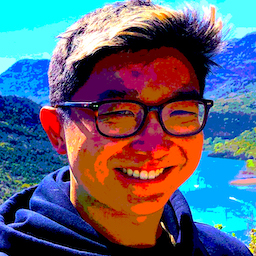

Button(description='Upload New File', style=ButtonStyle())

Output()

In [332]:
#@title Select or Upload an Image to Project {run: "auto"}

projection_source_images_outdir = "projection_source_images"
projection_source_vectors_outdir = "projection_source_vectors"

if not os.path.isdir(projection_source_images_outdir):
  !mkdir -p $projection_source_images_outdir

def upload_files():
  filepaths = []
  from google.colab import files
  uploaded = files.upload()
  for k, v in uploaded.items():
    filepath = f"{projection_source_images_outdir}/{k}"
    open(filepath, 'wb').write(v)
    filepaths.append(filepath)
  return list(filepaths)[0]


button = widgets.Button(description="Upload New File")
output = widgets.Output()

img_file_path = "projection_source_images/alan2.jpg" #@param {type: "string"}

def on_button_clicked(b):
  global img_file_path
  # Display the message within the output widget.
  # with output:
  img_file_path = upload_files();
  clear_output(wait=True)
  display(DisplayImage(img_file_path))

  print(color.BOLD + color.YELLOW + "NOTE: " + color.END + color.END +  "to save this upload for future runs, copy the line below into img_file_path param in the form");
  print("\t" + img_file_path)

  print("");
  display(button, output)

display(DisplayImage(img_file_path))

button.on_click(on_button_clicked)
display(button, output)

### Projection Into GAN Space

Generate a projection into the GAN latent by either:
  1. Entering a path to an existing projection
  2. Running the projection script on the image selected above

**Note:** only run *either* step 1 or step 2 (not both)

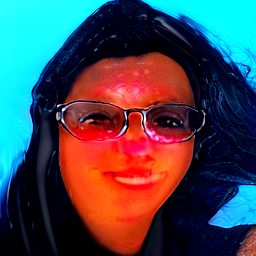

In [370]:
#@title EITHER: Select a path to an existing projection {run: "auto"}
projected_w_path = "/content/drive/MyDrive/stylegan3-fun-blend/projection_source_vectors/00011-projection-wplus-wavgstart-sgan2/projected_wplus_wavg_final.npy" #@param {type: "string"}

if projected_w_path:
  im1 = synthesize_img_from_w_path(G, projected_w_path)
  display(im1)

Loading networks from "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-ffhqu-256x256.pkl"...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Projecting in W+ latent space...
Starting from W midpoint using 10000 samples...
Completed 0 of 10
Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.
step 10/10: dist 6.6964650e-01 | loss 6.6964650e-01
Elapsed time: 3s
Creating output directory...
Saving projection results...
torch.Size([16, 512])
tensor([[ 0.1007,  0.2078,  0.3057,  ...,  0.2722,  0.2404,  0.2357],
        [ 0.6318, -0.1366, -0.1519,  ..., -0.1685, -0.0775,  0.3027],
        [-0.1253,  0.4477,  0.6771,  ...,  0.5960,  0.4839,  0.5083],
        ...,
        [-0.4561,  0.2974, -0.0914,  ..., -0.2657,  0.3305, -0.3280],
        [-0.0794, -0.0991, -0.1319,  ...,  0.7266,  0.3123, -0.0371],
        [ 0.3573,  0.6215,  0.4146,  ...,  0.8064,  0.3271,  0.5891]],
       device='cuda:0')
Saving optimization progress video "projectio

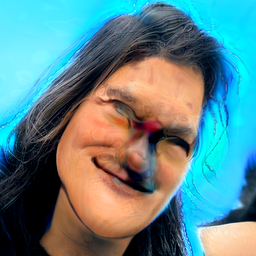

In [371]:
#@title OR: Create a new projection from selected photo
projection_source_vectors_outdir = "projection_source_vectors"

num_steps =  5000 #@param {type: "integer", min:0, max:10000, step:1, width: 10}

!python projector.py --outdir=$projection_source_vectors_outdir --target=$img_file_path --project-in-wplus --num-steps=$num_steps --save-video --stabilize-projection \
    --network=$source_model_pkl
print("Projection complete! \n\n")

last_projected_source_vector_dir= os.listdir(projection_source_vectors_outdir)[-1]
last_projected_source_vector_path = f"{projection_source_vectors_outdir}/{last_projected_source_vector_dir}"

projected_w_filename = [f for f in os.listdir(last_projected_source_vector_path) if f.endswith('.npy')][0]
projected_w_path = f"{last_projected_source_vector_path}/{projected_w_filename}"

print(f"Projected w at {projected_w_path}")

im1 = synthesize_img_from_w_path(G, projected_w_path)
display(im1)


### Interactive Blending

In [33]:
def doBlend(blend_thresh=7): 
  newDictSynt = G_tuned.synthesis.state_dict().copy()
  GSyntKeys = G.synthesis.state_dict().keys()

  for key in GSyntKeys:
    if key[:1] != 'L' : continue
    
    if int(key.split('_')[0][1:]) > blend_thresh: l = 1
    else: l = 0
    if 'affine' in key: l = 0

    newDictSynt[key] = newDictSynt[key]*l + G.synthesis.state_dict()[key]*(1-l)

  G_new.synthesis.load_state_dict(newDictSynt)

doBlend()

In [66]:
#Blend using mask. Number of layers in stylegan3 depends on config and not on gen resolution, as it was with stylegan2.

# blend = [0,0,0,0,0,0,0,0.2,0.5,0.7,0.9,1,1,1,1]
# blend = [0,0,0,0,0,0,0,0.2,0.5,0.7,0.8,.8,.8,.8,.8]
blend = [0,0,0,0,0,0.2,0.2,0.2,0.5,0.7,0.8,.8,.8,.8,1]
# blend = [0]*7+[0.8]*(15-7)

# Not blending affine layers gives us colors closer to the original gen, without affecting the geometry much.
def doBlend(): 
  newDictSynt = G_tuned.synthesis.state_dict().copy()
  GSyntKeys = G.synthesis.state_dict().keys()

  for key in GSyntKeys:
    if key[:1]!='L': continue
    l = blend[int(key.split('_')[0][1:])]
    if 'affine' in key: l = 0
    newDictSynt[key] = newDictSynt[key]*l + G.synthesis.state_dict()[key]*(1-l)

  G_new.synthesis.load_state_dict(newDictSynt)

doBlend()

<PIL.Image.Image image mode=RGB size=768x256 at 0x7F06DBA2E190>


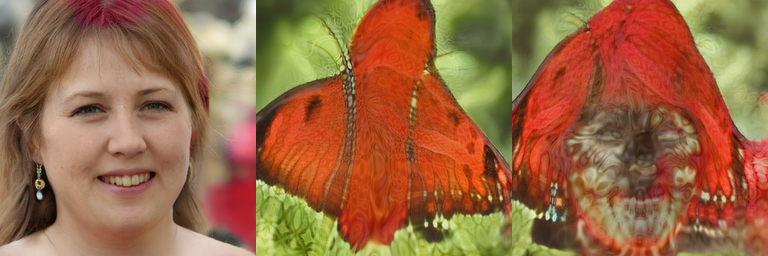

In [280]:
#@title Test { run: "auto" }
seed =  683 #@param {type:"slider", min:0, max:10000, step:1}
blend_thresh = 7 #@param {type:"slider", min:0, max:13, step:1}

blend_val_0 = 0 #@param {type:"slider", min:0, max:1, step:0.001}
blend_val_1 = 0 #@param {type:"slider", min:0, max:1, step:0.01}
blend_val_2 = 0 #@param {type:"slider", min:0, max:1, step:0.01}
blend_val_3 = 0.5 #@param {type:"slider", min:0, max:1, step:0.01}
blend_val_4 = 0.5 #@param {type:"slider", min:0, max:1, step:0.01}
blend_val_5 = 1 #@param {type:"slider", min:0, max:1, step:0.01}
blend_val_6 = 1 #@param {type:"slider", min:0, max:1, step:0.01}
blend_val_7 = 1 #@param {type:"slider", min:0, max:1, step:0.01}
blend_val_8 = 1 #@param {type:"slider", min:0, max:1, step:0.01}
blend_val_9 = 1 #@param {type:"slider", min:0, max:1, step:0.01}
blend_val_10 = 1 #@param {type:"slider", min:0, max:1, step:0.01}
blend_val_11 = 1 #@param {type:"slider", min:0, max:1, step:0.01}
blend_val_12 = 1 #@param {type:"slider", min:0, max:1, step:0.01}
blend_val_13 = 0.5 #@param {type:"slider", min:0, max:1, step:0.01}
blend_val_14 = 0.57 #@param {type:"slider", min:0, max:1, step:0.01}

# blend = [0,0,0,0,0,0.2,0.2,0.2,0.5,0.7,0.8,.8,.8,.8,1]
blend = [blend_val_0, blend_val_1, blend_val_2, blend_val_3, blend_val_4, blend_val_5, blend_val_6, blend_val_7, blend_val_8, blend_val_9, blend_val_10, blend_val_11, blend_val_12, blend_val_13, blend_val_14]
psi = 0.5

bl_str = ('_').join([str(o) for o in blend])
net = destination_model_pkl.split('/')[-1]
rnd = np.random.RandomState(seed)
z = torch.tensor(rnd.randn(1,G.z_dim)).cuda()

doBlend()
w = G.mapping(z, None, truncation_psi=psi, truncation_cutoff=8)

im1 = G.synthesis(w, noise_mode='const', force_fp32=True)
im2 = G_tuned.synthesis(w, noise_mode='const', force_fp32=True)
im3 = G_new.synthesis(w, noise_mode='const', force_fp32=True)
im1 = t2i(im1)
im2 = t2i(im2)
im3 = t2i(im3)
im = add_imgs([im1, im2, im3])
# im.save(f'/content/m{net}_psi{psi}_b{bl_str}_s{seed}.jpg')
im

In [160]:
blen_val_14 = 0.2